# Stock analysis

## Import

Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import yfinance as yf

Definitions

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
index_tickers = ['SFY', 'STW', 'VAS']

## Get data

Define Functions

In [4]:
def get_prices(ticker: str, start_date: str, end_date: str = None, interval: str = '1d') -> pd.DataFrame:
    """ 
    Get historical prices for a given ticker.

    Parameters:
        - ticker (str): The ticker symbol of the stock.
        - start (str): The start date of the historical prices.
        - end_str (str): (default=None) The end date of the historical prices.
        - interval (str): (default='1d') The interval of the historical prices.
    """

    price_df_list = []

    if end_date is None:
        end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    # get prices for each year and concat to get the full price_df
    for year in range(start_year, end_year + 1):
        if year == start_year:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=start_date, end=f'{year}-12-31')
        elif year == end_year:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=f'{year}-01-01', end=end_date)
        else:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=f'{year}-01-01', end=f'{year}-12-31')

        price_df_list.append(price_df)

    price_df = pd.concat(price_df_list)

    price_df['Dividends'] = price_df['Dividends'].astype(float)

    return price_df

In [5]:
def get_return(price_df: pd.DataFrame, interval: str = 'M') -> pd.DataFrame:
    """ 
    Get return of stock on a monthly basis (last close price/last close price previous period - 1)

        - pride_df: pd.DataFrame
        - interval: str (default='M')
    """
    assert interval in ['M', 'Q', 'Y'], 'interval must be M, Q or Y'

    # find the last close price of each period
    last_close_price = price_df.resample(interval).last()

    # calculate the return
    return_series = last_close_price['Close'].pct_change()*100

    # turn into a dataframe
    return_series = return_series.to_frame()

    return_series.columns = [f'{interval}_Return (%)']
    # set index to month
    return_series.index = return_series.index.strftime('%Y-%m')

    return return_series

In [6]:
def get_stats(monthly_returns_df_dict: str, ticker: str, start_period: str, end_year: str):

    period_of_interest_return_df = monthly_returns_df_dict[ticker].loc[start_period:end_year]

    stats_dict = {}

    # mean, std, n
    stats_dict['mean (%)'] = np.round(
        period_of_interest_return_df.mean().values[0], 2)
    stats_dict['std (%)'] = np.round(
        period_of_interest_return_df.std().values[0], 2)
    stats_dict['n'] = period_of_interest_return_df.shape[0]

    # sharpe
    mode = monthly_returns_df_dict[ticker].columns[0].split('_')[0]
    sharpe_multiplier = 4 if mode == 'Q' else 12 if mode == 'M' else 1
    stats_dict['sharpe'] = np.round(np.sqrt(
        sharpe_multiplier) * stats_dict['mean (%)'] / stats_dict['std (%)'], 2)
    
    # earliest and latest date for ticker
    regression_start_period = monthly_returns_df_dict[ticker].index[1]
    regression_end_period = monthly_returns_df_dict[ticker].index[-1]

    # beta over this period
    X = monthly_returns_df_dict['SFY'].loc[regression_start_period:regression_end_period][f'{mode}_Return (%)']
    X = sm.add_constant(X)
    y = monthly_returns_df_dict[ticker].loc[regression_start_period:regression_end_period][f'{mode}_Return (%)']

    linreg = sm.OLS(y, X).fit()
    stats_dict['CAPM beta'] = np.round(linreg.params[f'{mode}_Return (%)'], 2)
    stats_dict['CAPM alpha'] = np.round(linreg.params['const'], 2)
    

    return stats_dict

In [7]:
def historical_corr(monthly_returns_df_dict: dict, start_period: str, end_year: str):
    """
    Get the historical correlation between two stocks.

    Parameters:
        - historical_returns: dict
        - start_period: str
        - end_year: str
    """

    period_of_interest_return_df = pd.DataFrame()

    for ticker, returns_df in monthly_returns_df_dict.items():
        returns_df = returns_df.loc[start_period:end_year]
        returns_df.rename(
            columns={returns_df.columns[0]: ticker}, inplace=True)

        period_of_interest_return_df = pd.merge(
            period_of_interest_return_df, returns_df, left_index=True, right_index=True, how='outer')

    # calculate correlation: corr() function from pandas
    correlation_df = period_of_interest_return_df.corr()  # TODO

    return correlation_df, period_of_interest_return_df

In [109]:
def plot_returns(monthly_returns_df_dict: dict, quarterly_returns_df_dict: dict, yearly_returns_df_dict: dict, TICKER: str, first_end_of_quarter: str, last_end_of_quarter: str, **kwargs):

    # Create a figure and 3 subplots
    fig, axs = plt.subplots(3, 1, figsize=(8, 8))

    interested_monthly_returns_df = monthly_returns_df_dict[TICKER][monthly_returns_df_dict[TICKER].index > first_end_of_quarter]
    interested_quarterly_returns_df = quarterly_returns_df_dict[TICKER][quarterly_returns_df_dict[TICKER].index > first_end_of_quarter]
    interested_yearly_returns_df = yearly_returns_df_dict[TICKER][yearly_returns_df_dict[TICKER].index > first_end_of_quarter]

    # Plot monthly returns as a bar chart
    axs[0].bar(interested_monthly_returns_df.index, interested_monthly_returns_df.values.flatten(), label='Monthly Returns (%)', color='red')
    axs[0].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[0].set_title('Monthly Returns (%)')
    axs[0].set_ylabel('Returns (%)')
    axs[0].set_xticks(np.arange(0, len(interested_monthly_returns_df), 3))
    axs[0].tick_params(axis='x', rotation=90)

    # Plot quarterly returns as a bar chart
    axs[1].bar(interested_quarterly_returns_df.index, interested_quarterly_returns_df.values.flatten(), label='Quarterly Returns (%)', color='orange')
    axs[1].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[1].set_title('Quarterly Returns (%)')
    axs[1].set_ylabel('Returns (%)')
    axs[1].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels

    # Add text above the bars for quarterly returns
    for i, value in enumerate(interested_quarterly_returns_df.values.flatten()):
        axs[1].text(i, value, f'{value:.1f}%', ha='center', va='bottom', fontsize=8, rotation=45)


    # Plot yearly returns as a bar chart
    axs[2].bar(interested_yearly_returns_df.index, interested_yearly_returns_df.values.flatten(), label='Yearly Returns (%)', color='yellow')
    axs[2].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[2].set_title('Yearly Returns (%)')
    axs[2].set_ylabel('Returns (%)')
    axs[2].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels

    # Add text above the bars for quarterly returns
    for i, value in enumerate(interested_yearly_returns_df.values.flatten()):
        axs[2].text(i, value, f'{value:.1f}%', ha='center', va='bottom', fontsize=8, rotation=45)


    # Set x-label only on the last subplot
    axs[2].set_xlabel('Date')

    fig.suptitle(f'{TICKER} Returns from {first_end_of_quarter} to {last_end_of_quarter}', fontsize=16)

    # Rotate x-axis labels 90 degrees on the last subplot
    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)

    # Tight layout for better spacing between plots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [102]:
def plot_correlation(correlation_df: pd.DataFrame):
    """
    Plot the correlation matrix.

    Parameters:
        - correlation_df: pd.DataFrame
    """
    plt.figure(figsize=(10, 8))
    # Set vmin and vmax to -1 and 1, respectively, and use the custom colormap
    plt.matshow(correlation_df, fignum=1, vmin=-1, vmax=1, cmap = "RdBu")
    plt.xticks(range(len(correlation_df.columns)), correlation_df.columns, rotation=45)
    plt.yticks(range(len(correlation_df.columns)), correlation_df.columns)
    # Colour bar with the custom colormap
    plt.colorbar()
    plt.title(f'{TICKER} Monthly Return Correlation Matrix')
    plt.show()

Run data

In [103]:
TICKER = 'NVX'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'

In [84]:
asx_companies_directory = pd.read_csv('../data/asx_companies_directory.csv')
gics = pd.read_csv('../data/asx_gics.csv')

asx_companies_directory['Market Cap'] = asx_companies_directory['Market Cap'].apply(lambda x: int(x) if x.isnumeric() else x)

In [85]:
asx_companies_directory

,ASX code,Company name,GICs industry group,Listing date,Market Cap
0,14D,1414 DEGREES LIMITED,Capital Goods,12/09/2018,15004617
1,1AD,ADALTA LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",22/08/2016,10911700
2,1AE,AURORA ENERGY METALS LIMITED,Materials,18/05/2022,7520677
3,1AI,ALGORAE PHARMACEUTICALS LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",01/09/2004,11811763
4,1CG,ONE CLICK GROUP LIMITED,Capital Goods,28/04/2017,7747935
...,...,...,...,...,...
1950,ZLD,ZELIRA THERAPEUTICS LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",28/07/2003,8396895
1951,ZMI,ZINC OF IRELAND NL,Materials,18/09/2007,2125243
1952,ZMM,ZIMI LIMITED,Technology Hardware & Equipment,10/09/2007,1519977
1953,ZNC,ZENITH MINERALS LIMITED,Materials,29/05/2007,15152378


In [86]:
# find same industry stocks
ticker_gics_sector = gics[gics['Ticker'] == f'{TICKER}.AX']['Sector'].values[0]
ticker_gics_industry = gics[gics['Ticker'] == f'{TICKER}.AX']['Industry'].values[0]

same_sector_tickers = gics[gics['Sector'] == ticker_gics_sector]['Ticker'].values
same_industry_tickers = gics[gics['Industry'] == ticker_gics_industry]['Ticker'].values
same_sector_and_gics_tickers = gics[(gics['Sector'] == ticker_gics_sector) & (gics['Industry'] == ticker_gics_industry)]['Ticker'].values

In [87]:
# get market caps and weight
market_cap = asx_companies_directory[((asx_companies_directory['ASX code']+'.AX').isin(same_sector_and_gics_tickers)) & (asx_companies_directory['ASX code'] != TICKER)][['ASX code', 'Market Cap']]
# check for is integer
market_cap = market_cap[market_cap['Market Cap'].apply(lambda x: isinstance(x, int))]

In [88]:
market_cap['weight'] = market_cap['Market Cap']/market_cap['Market Cap'].sum()

In [89]:
market_cap = market_cap.sort_values(by='Market Cap', ascending=False)
display(market_cap)

ticker_mv = asx_companies_directory[asx_companies_directory['ASX code'] == TICKER][['ASX code', 'Market Cap']]
display(ticker_mv)

print(ticker_mv['Market Cap'].values[0]/market_cap['Market Cap'].sum())

,ASX code,Market Cap,weight
1631,SKS,156897831,0.392738
599,ECL,86983407,0.217732
1051,LIS,76824028,0.192302
1425,PPK,34185749,0.085572
617,EGY,14772618,0.036978
726,FOS,13989596,0.035018
1514,RFT,9679464,0.024229
449,CMX,4644804,0.011627
1952,ZMM,1519977,0.003805


,ASX code,Market Cap
1281,NVX,269048949


0.6734684610296184


In [27]:
my_portfolio_tickers = [TICKER]
my_portfolio_tickers.extend([ticker.split('.')[0] for ticker in same_sector_and_gics_tickers if ticker.split('.')[0] != TICKER ])


my_portfolio_tickers.extend(index_tickers)

historical_prices = {}

for ticker in my_portfolio_tickers:
    historical_prices[ticker] = get_prices(f'{ticker}.AX', '2019-06-01')

$CMX.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$CMX.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$CMX.AX: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-12-31) (Yahoo error = "Data doesn't exist for startDate = 1609419600, endDate = 1640869200")
$FOS.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FOS.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$LIS.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$LIS.AX: p

In [90]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    monthly_returns_df_dict[ticker] = get_return(price_df, 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    quarterly_returns_df_dict[ticker] = get_return(price_df, 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    yearly_returns_df_dict[ticker] = get_return(price_df, 'Y')

In [91]:
stats_dict = {}

for ticker in my_portfolio_tickers:
    stats_dict[ticker] = get_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)
    
stats_df = pd.DataFrame(stats_dict).T
stats_df

,mean (%),std (%),n,sharpe,CAPM beta,CAPM alpha
NVX,5.67,34.51,49.0,0.57,1.95,3.69
CMX,-3.95,16.44,30.0,-0.83,1.21,-5.68
ECL,2.42,7.22,49.0,1.16,0.15,1.86
EGY,-2.09,14.79,49.0,-0.49,0.43,-2.65
FOS,1.24,13.11,37.0,0.33,0.05,1.56
LIS,-6.48,19.47,34.0,-1.15,1.41,-7.01
PPK,-2.07,24.47,49.0,-0.29,2.40,-1.69
RFT,-1.67,17.76,49.0,-0.33,1.46,-2.18
RFX,-0.65,20.41,49.0,-0.11,0.89,-1.10
SKS,9.11,24.97,49.0,1.26,0.38,6.07


In [92]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)
# correlation_df.round(2)

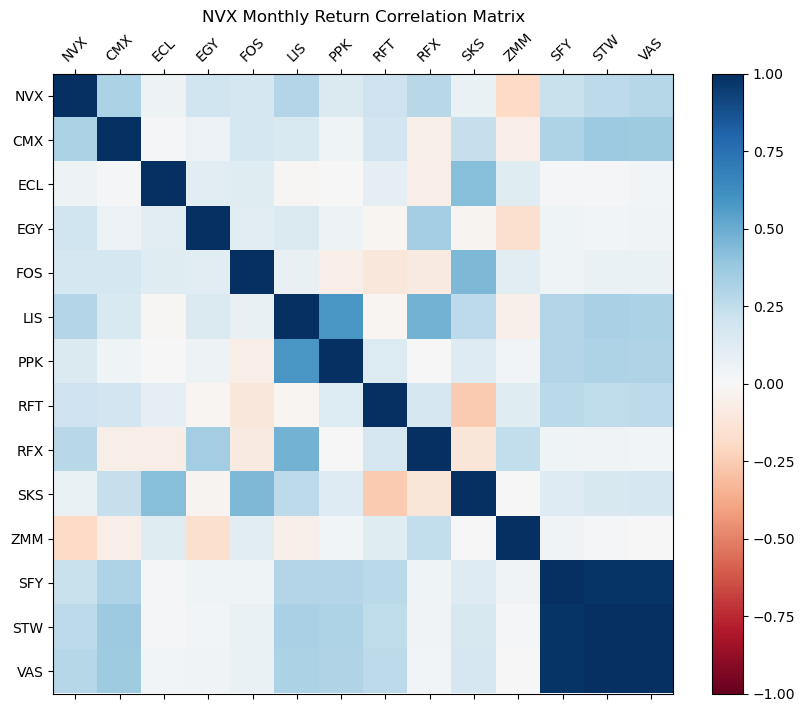

In [93]:
plot_correlation(correlation_df)

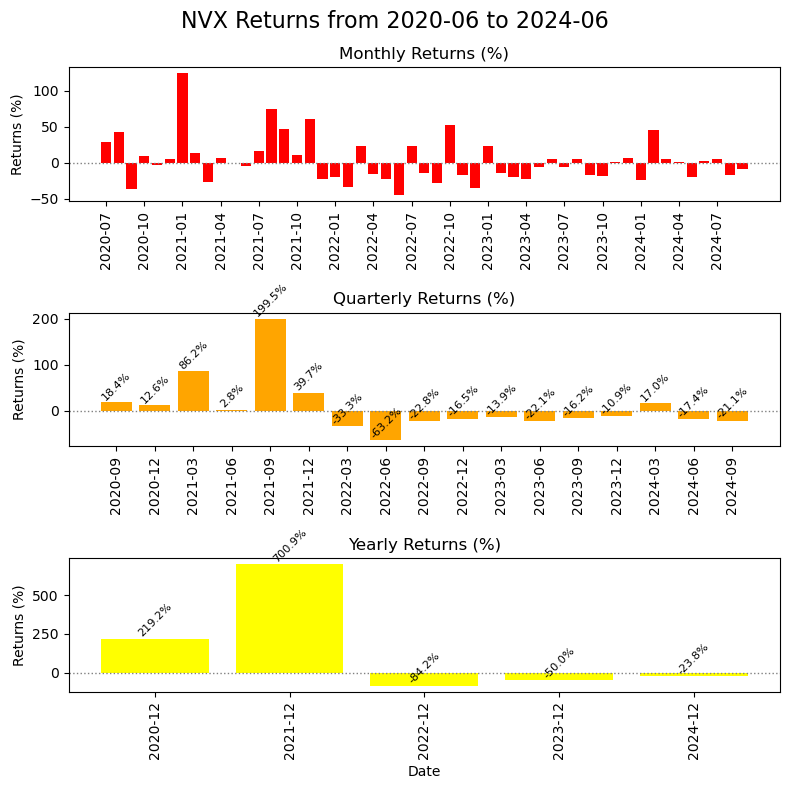

In [110]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict, 
              'quarterly_returns_df_dict': quarterly_returns_df_dict, 
              'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER, 
              'first_end_of_quarter': first_end_of_quarter, 
              'last_end_of_quarter': last_end_of_quarter})

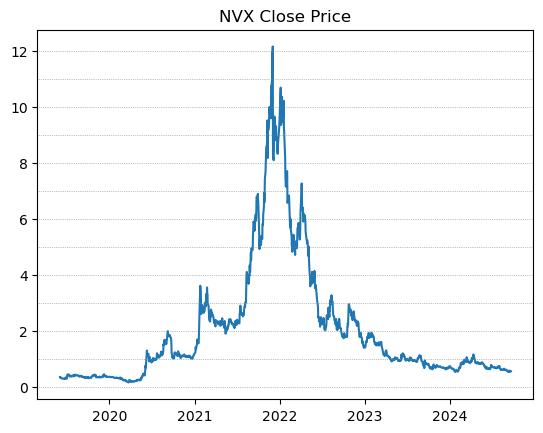

In [111]:
# TODO: recent plot - different intervals

plt.title(f'{TICKER} Close Price')
plt.plot(historical_prices[TICKER]['Close'])
# plot some horizontal lines at each dollar (dotted faint line)
for i in range(int(np.ceil(historical_prices[TICKER]['Close'].min())-1), int(np.floor(historical_prices[TICKER]['Close'].max()))+1):
    plt.axhline(y=i, color='gray', linestyle=':', linewidth=0.5)
plt.show()

In [112]:
# dividends
display(historical_prices[TICKER][historical_prices[TICKER]
                                  ['Dividends'] > 0][['Dividends']])

,Dividends
Date,


In [114]:
# stock splits
display(historical_prices[TICKER][historical_prices[TICKER]['Stock Splits'] > 0][['Stock Splits']])

,Stock Splits
Date,


In [21]:
assert False

AssertionError: 

# Other Stats

In [231]:
TICKER = 'TWE'

In [232]:
object = yf.Ticker(f'{TICKER}.AX')

In [233]:
object.analyst_price_targets

{'current': 10.97, 'low': 11.5, 'high': 16.0, 'mean': 13.99, 'median': 14.5}

In [242]:
balance_sheet_row = ['Ordinary Shares Number', 'Share Issued', 'Total Debt',
       'Tangible Book Value', 'Invested Capital', 'Working Capital',
       'Common Stock Equity', 'Total Capitalization',
       'Stockholders Equity',
       'Retained Earnings',
        'Current Liabilities',
       'Current Debt And Capital Lease Obligation',
        'Total Assets',
       'Cash Cash Equivalents And Short Term Investments']

object.balance_sheet.loc[balance_sheet_row]

,2024-06-30,2023-06-30,2022-06-30,2021-06-30,2020-06-30
Ordinary Shares Number,811426445.0,729346698.0,729346698.0,729346698.0,NaN
Share Issued,811426445.0,729346698.0,729346698.0,729346698.0,NaN
Total Debt,2158500000.0,1937600000.0,1673700000.0,1527800000.0,NaN
Tangible Book Value,2411000000.0,2435000000.0,2385100000.0,2431600000.0,NaN
Invested Capital,6752300000.0,5799300000.0,5458600000.0,5114900000.0,NaN
Working Capital,1158100000.0,1138800000.0,986600000.0,1178800000.0,NaN
Common Stock Equity,4593800000.0,3861700000.0,3784900000.0,3587100000.0,NaN
Total Capitalization,6668500000.0,5548600000.0,5297100000.0,5061800000.0,NaN
Stockholders Equity,4593800000.0,3861700000.0,3784900000.0,3587100000.0,NaN
Retained Earnings,302900000.0,464600000.0,455500000.0,394400000.0,NaN


In [237]:
cashflow_row = ['Free Cash Flow', 'Repayment Of Debt',
       'Issuance Of Debt', 'Issuance Of Capital Stock', 'Capital Expenditure',
       'End Cash Position', 
       'Changes In Cash', 'Financing Cash Flow',
       'Investing Cash Flow']

# 'Repurchase Of Capital Stock'

object.cashflow.loc[cashflow_row]

,2024-06-30,2023-06-30,2022-06-30,2021-06-30,2020-06-30
Free Cash Flow,241600000.0,23000000.0,449800000.0,350500000.0,NaN
Repayment Of Debt,-698800000.0,-154100000.0,-301100000.0,-463200000.0,NaN
Issuance Of Debt,921300000.0,394200000.0,335700000.0,217400000.0,NaN
Issuance Of Capital Stock,807000000.0,NaN,NaN,NaN,NaN
Capital Expenditure,-190100000.0,-249000000.0,-112200000.0,-121200000.0,NaN
End Cash Position,458100000.0,565800000.0,430500000.0,448100000.0,NaN
Changes In Cash,-105200000.0,133400000.0,-31400000.0,8700000.0,NaN
Financing Cash Flow,783000000.0,-27200000.0,-184800000.0,-403600000.0,NaN
Investing Cash Flow,-1319900000.0,-111400000.0,-408600000.0,-59400000.0,NaN
Cash Flow From Continuing Investing Activities,-1319900000.0,-111400000.0,-408600000.0,-59400000.0,NaN


In [240]:
financial_row = ['EBITDA',
       'EBIT', 
       'Basic EPS', 'Net Income', 
       'Operating Income', 'Operating Expense',
       'Gross Profit', 'Cost Of Revenue', 'Total Revenue']

object.financials.loc[financial_row]

,2024-06-30,2023-06-30,2022-06-30,2021-06-30,2020-06-30
EBITDA,528900000.0,651000000.0,644400000.0,615300000.0,NaN
EBIT,373400000.0,489300000.0,495800000.0,464600000.0,NaN
Basic EPS,NaN,0.349371,0.361247,0.343432,0.358278
Net Income,98900000.0,254500000.0,263200000.0,250000000.0,NaN
Operating Income,42600000.0,182700000.0,240600000.0,166200000.0,NaN
Operating Expense,1123500000.0,826600000.0,747600000.0,744200000.0,NaN
Gross Profit,1166100000.0,1009300000.0,988200000.0,910400000.0,NaN
Cost Of Revenue,1573700000.0,1413700000.0,1488500000.0,1659200000.0,NaN
Total Revenue,2739800000.0,2423000000.0,2476700000.0,2569600000.0,NaN


In [239]:
object.info

{'address1': '161 Collins Street',
 'address2': 'Level 8',
 'city': 'Melbourne',
 'state': 'VIC',
 'zip': '3000',
 'country': 'Australia',
 'phone': '61 3 8533 3000',
 'fax': '61 3 9690 5196',
 'website': 'https://www.tweglobal.com',
 'industry': 'Beverages - Wineries & Distilleries',
 'industryKey': 'beverages-wineries-distilleries',
 'industryDisp': 'Beverages - Wineries & Distilleries',
 'sector': 'Consumer Defensive',
 'sectorKey': 'consumer-defensive',
 'sectorDisp': 'Consumer Defensive',
 'longBusinessSummary': "Treasury Wine Estates Limited operates as a wine company primarily in Australia, the United States, the United Kingdom, and internationally. The company engages in the viticulture and winemaking; and marketing, sale, and distribution of wine. Its wine portfolio includes luxury, premium and commercial wine brands, such as Penfolds, DAOU Vineyards, Wolf Blass, 19 Crimes, St Hubert's The Stag, Lindeman's, Squealing pig, Blossom Hill, Frank Family Vineyards, Pepperjack, Wynns